In [31]:
import pandas as pd
import inflection as ifn
from IPython.display import display
from IPython.display import Image
import numpy as np
import math
import seaborn as sns
from matplotlib import pyplot as plt
import datetime

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('Data/predictionStoreP03.csv', parse_dates=['date','year_week','competition_since','promo_since'])

### 3.0. Filtragem de variáveis

#### 3.1. Filtragem das linhas

In [8]:
df = data.loc[data['open'] != 0 & (data['sales'] > 0)]    

#### 3.0. Filtragem das colunas

In [10]:
df = df.drop(['customers','open','promo_interval', 'month_map'], axis=1)

### 4.0. Análise exploratória dos dados

In [29]:
sns.set(rc={'figure.figsize':(28,10)})

#### 4.1. Análise Univariada

##### 4.1.1 Análise isolda da target

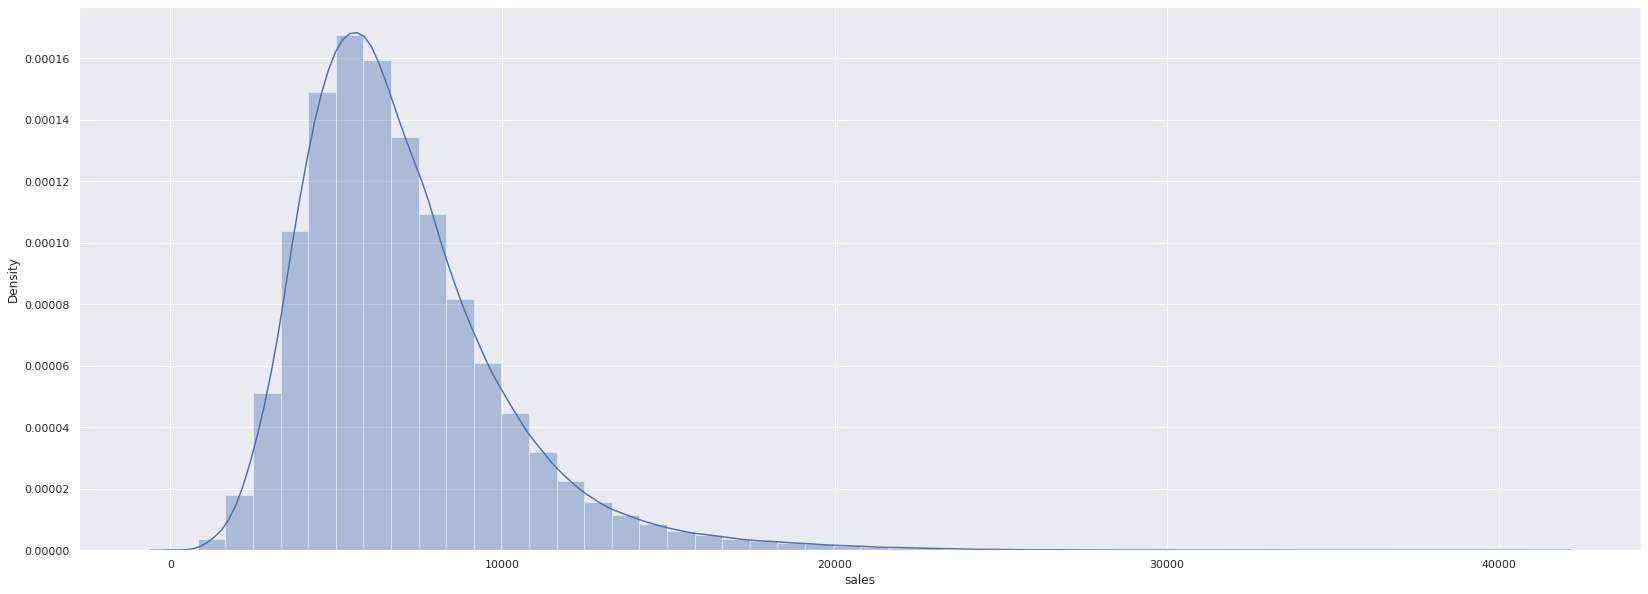

In [39]:
ax = sns.distplot(df.sales)

##### 4.1.2 Análise de variáveis numéricas

In [ ]:
num_atrib = df.select_dtypes(['int64','float64'])

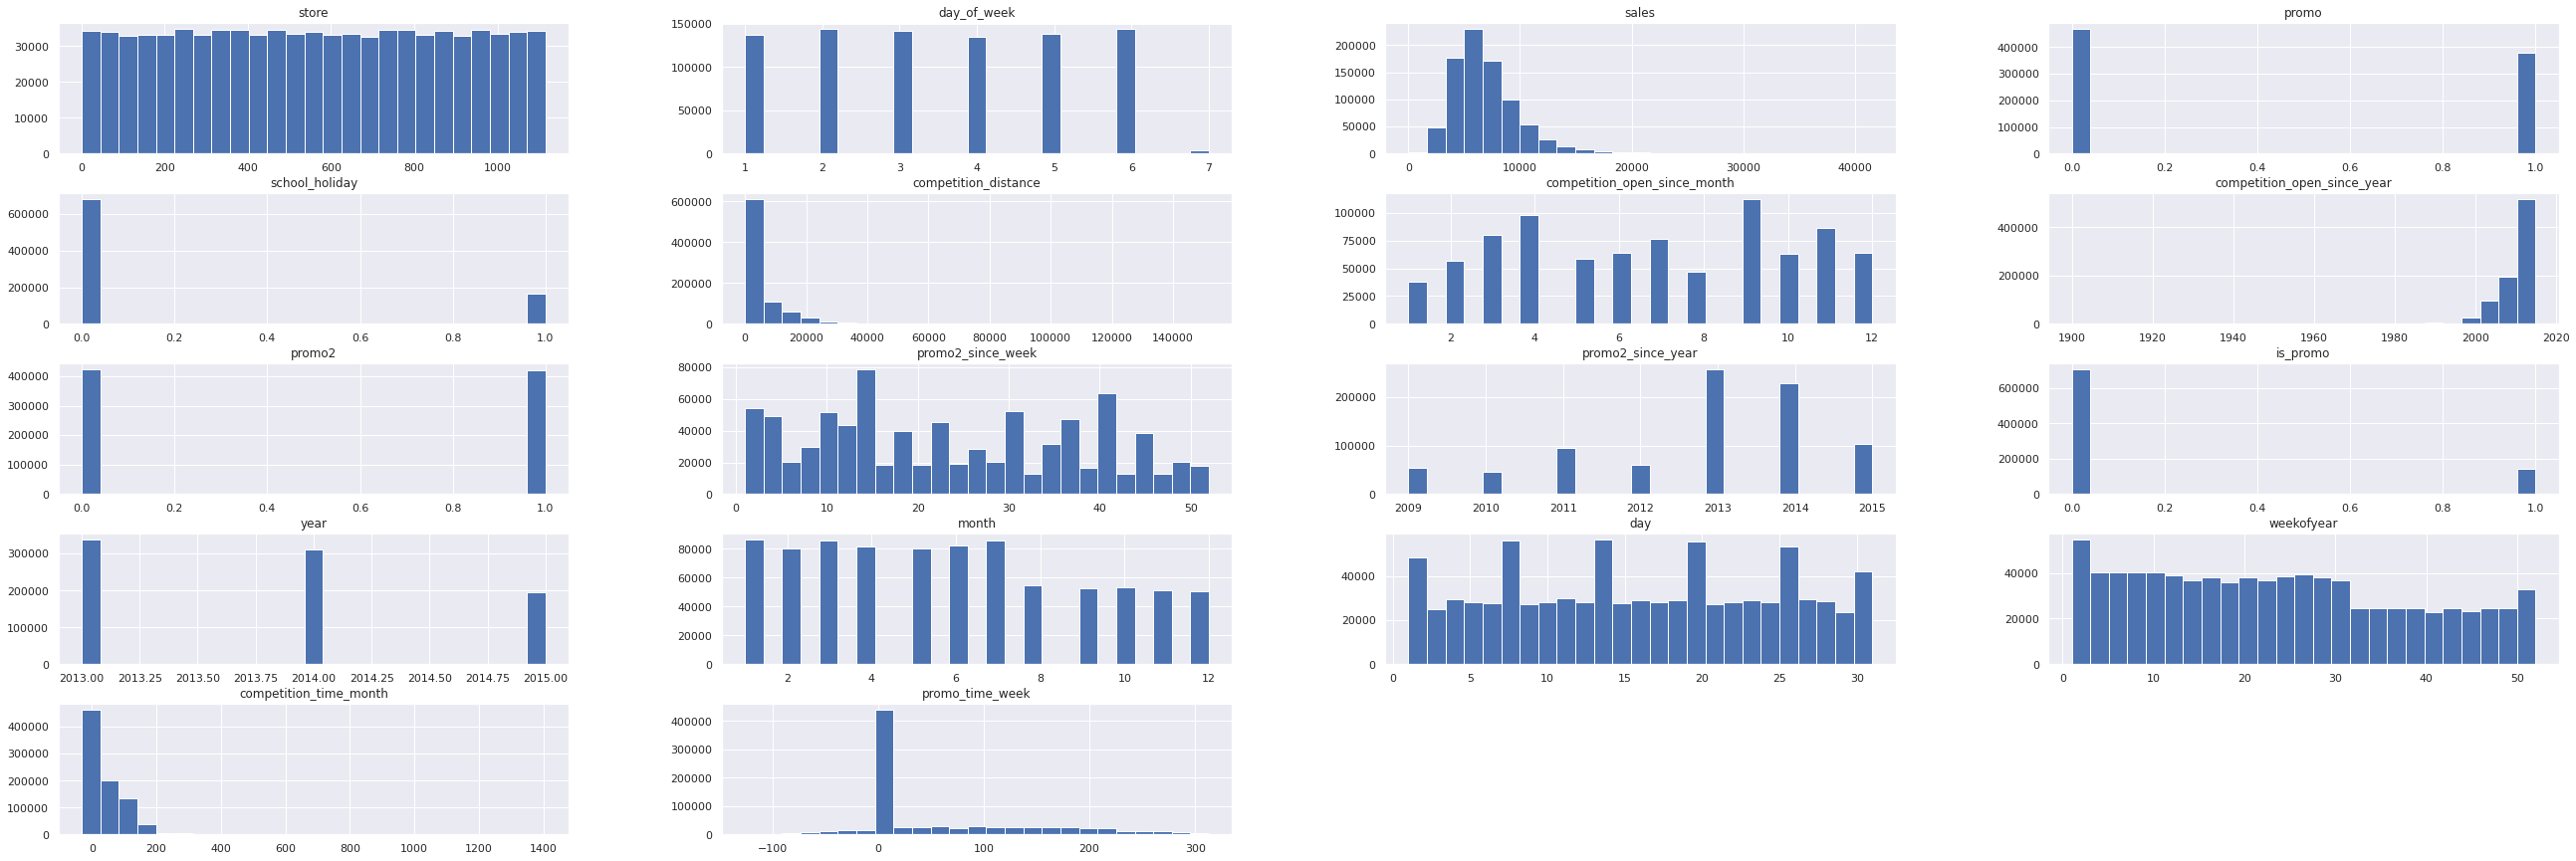

In [ ]:
num_atrib.hist(figsize=(45,15), bins=25);

In [73]:
num_atrib = df.select_dtypes(['int64','float64'])

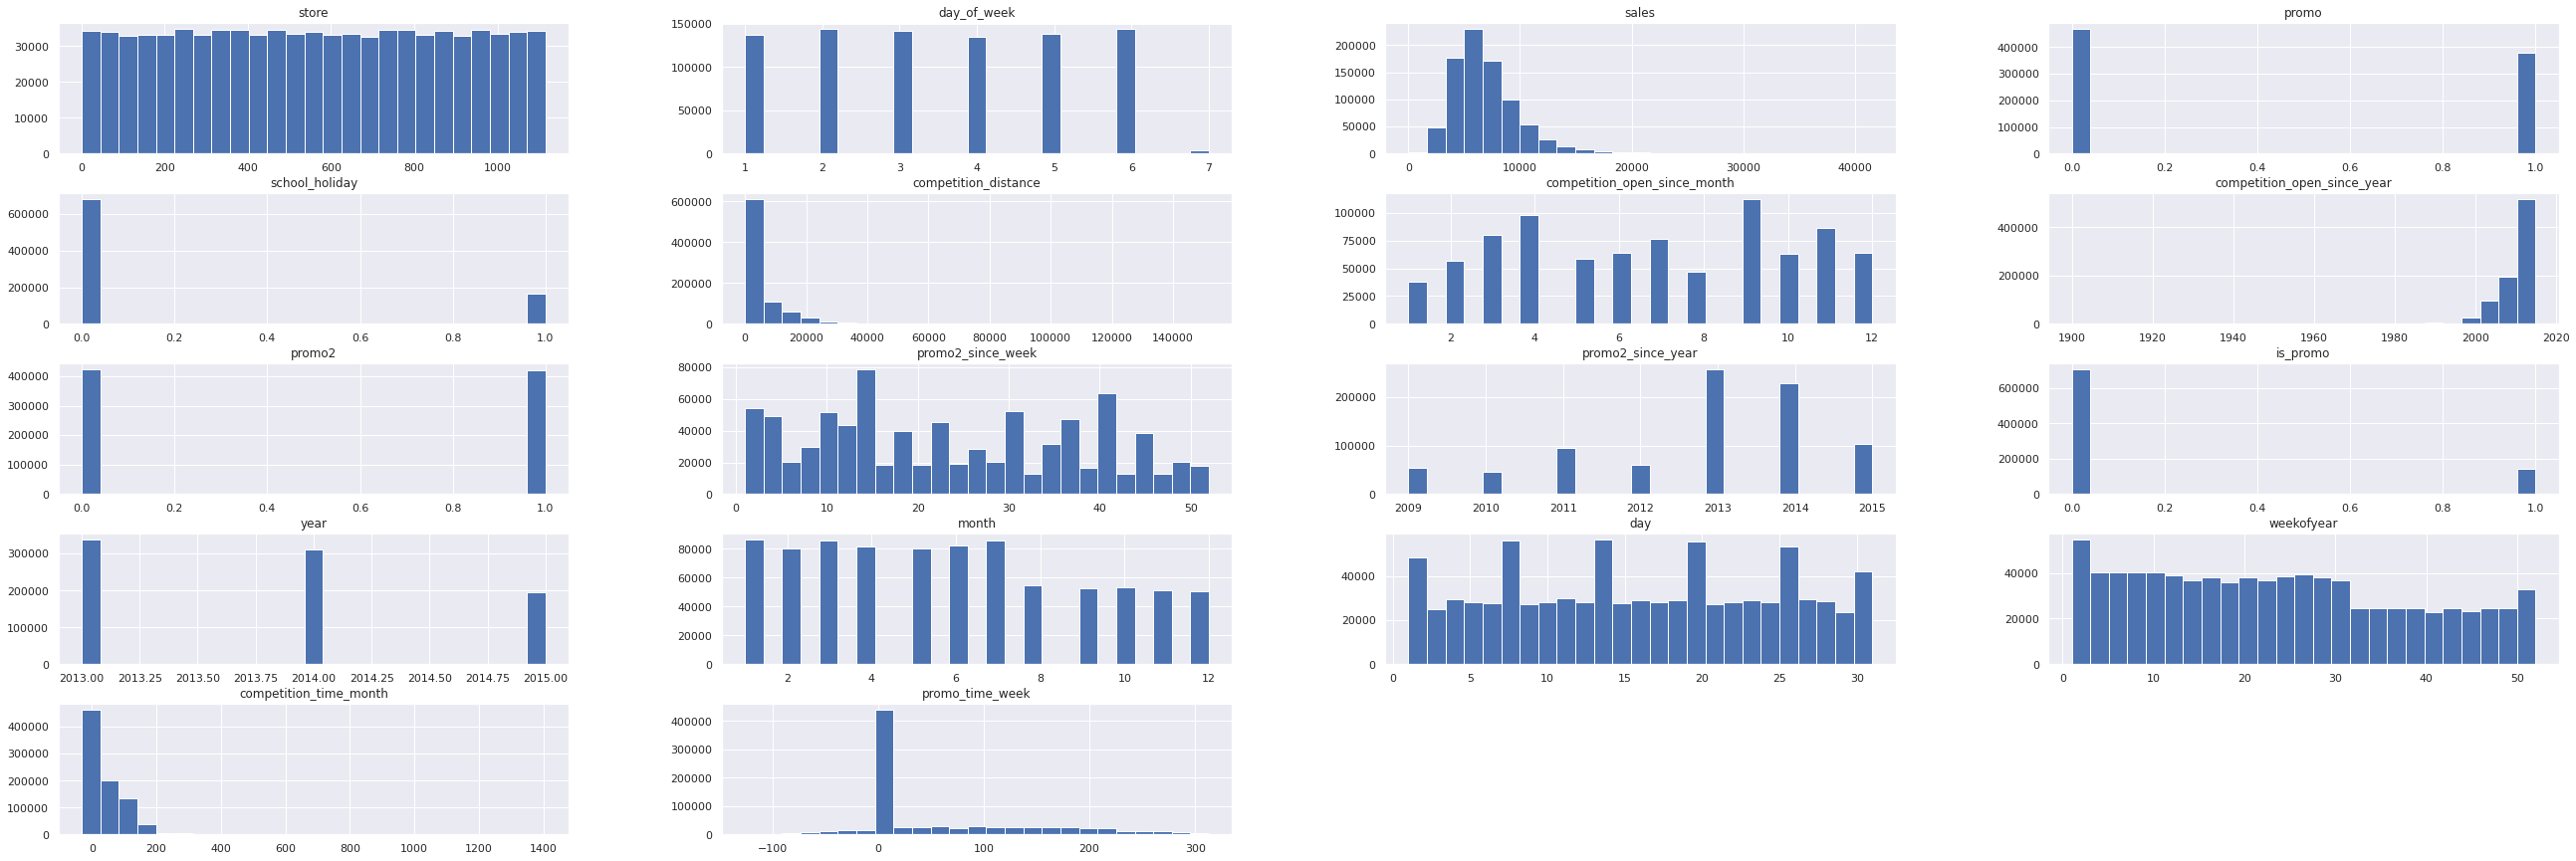

In [69]:
num_atrib.hist(figsize=(45,15), bins=25);

##### 4.1.3 Análise de variáveis categóricas

In [178]:
cat_atrib = df.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
cat_atrib.assortment.unique()

array(['basic', 'extended', 'extra'], dtype=object)

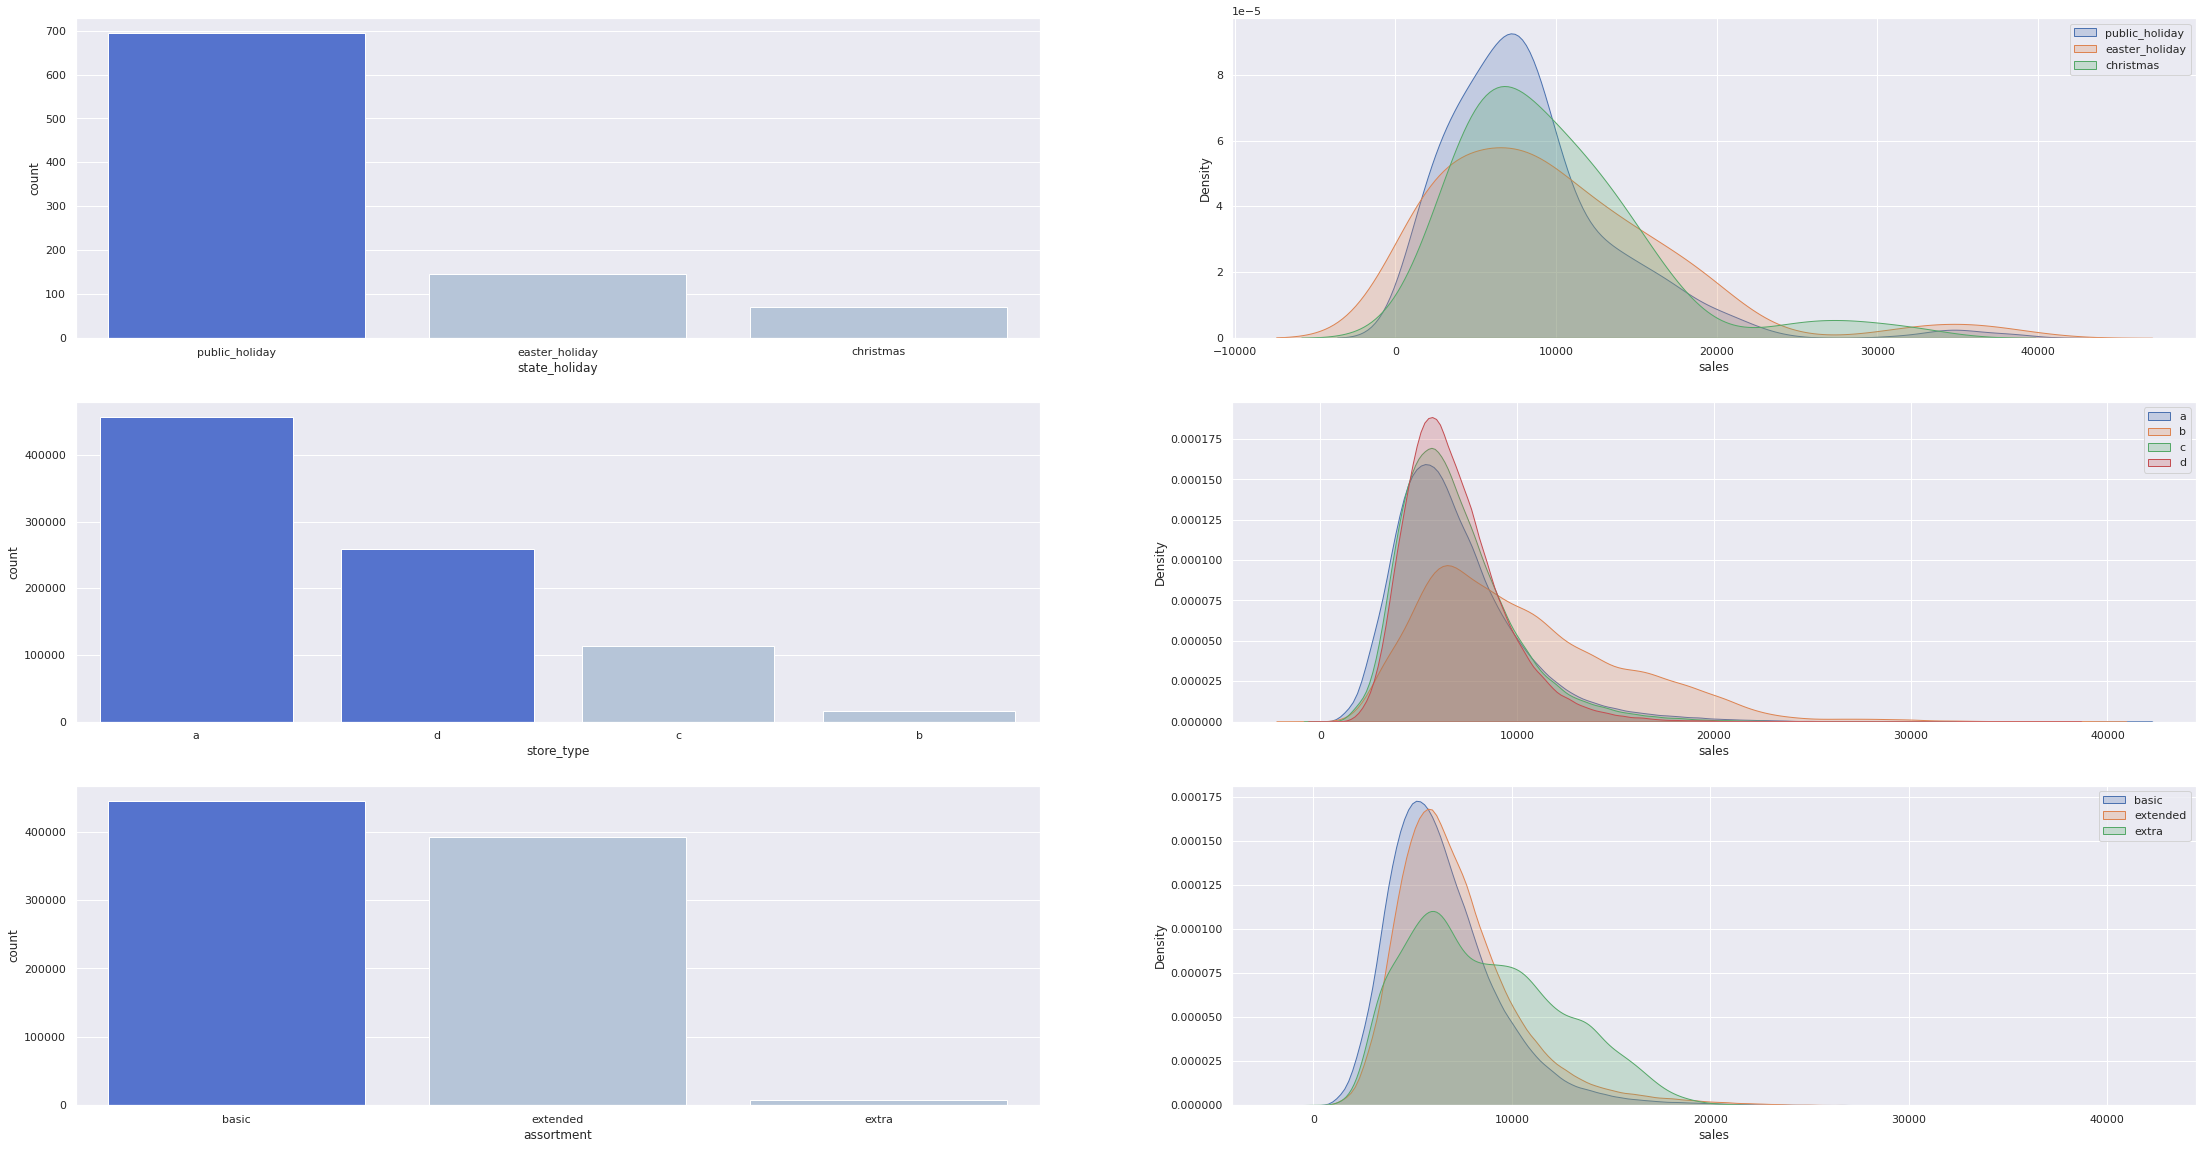

In [182]:
# state_holiday
sns.set(rc = {'figure.figsize' : (38,20)})

plt.subplot(3,2,1)
sns.countplot(cat_atrib.loc[cat_atrib['state_holiday'] != 'regular_day' , 'state_holiday'], palette= ['royalblue','lightsteelblue','lightsteelblue']);

plt.subplot(3,2,2)
sns.kdeplot(data=df[df['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(data=df[df['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(data=df[df['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)
plt.legend()

# story_type
plt.subplot(3,2,3)
sns.countplot(cat_atrib['store_type'], palette= ['royalblue','royalblue','lightsteelblue','lightsteelblue'], order='adcb');

plt.subplot(3,2,4)
sns.kdeplot(data=df[df['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(data=df[df['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(data=df[df['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(data=df[df['store_type'] == 'd']['sales'], label='d', shade=True)
plt.legend()

# assortment
plt.subplot(3,2,5)
sns.countplot(cat_atrib['assortment'], palette= ['royalblue','lightsteelblue','lightsteelblue']);

plt.subplot(3,2,6)
sns.kdeplot(data=df[df['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(data=df[df['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(data=df[df['assortment'] == 'extra']['sales'], label='extra', shade=True)
plt.legend()



#### 4.1. Análise Bivariada

#### 4.1. Análise Multivariada